<a href="https://colab.research.google.com/github/yiwenwangANU/Tensorflow_Advanced/blob/main/Siamese_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow.keras.datasets as tfds
from tensorflow.keras import layers

#`np.where`

In [2]:
a = np.arange(10)
np.where(a < 5)[0]

array([0, 1, 2, 3, 4])

In [3]:
np.where(a <5, a, a*a)

array([ 0,  1,  2,  3,  4, 25, 36, 49, 64, 81])

#Fashion Mnist from tfds

In [4]:
(X_train, y_train), (X_test, y_test) = tfds.fashion_mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

4431872/4422102 [==============================] - 0s 0us/step


In [5]:
y_train[:50]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1,
       4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5,
       9, 2, 7, 3, 0, 3], dtype=uint8)

#Data preprocessing

In [6]:
# digit_didices = [[] for i in range(10)]
# for i, label in enumerate(y_train):
#   digit_didices[label].append(i)

In [7]:
def create_indices(y):
  digit_indices = [np.where(y == i)[0] for i in range(10)]
  return digit_indices

In [8]:
def create_labeled_pairs(X, digit_indices):
  pairs = []
  labels = []

  n = min([len(index_list) for index_list in digit_indices])
  
  for d in range(10):
    for i in range(n-1):
      index_1, index_2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs.append([X[index_1], X[index_2]])
      labels.append(1)
      rd = (random.randint(1, 9) + d) % 10
      index_1, index_3 = digit_indices[d][i], digit_indices[rd][i]
      pairs.append([X[index_1], X[index_3]])
      labels.append(0)

  return np.array(pairs), np.array(labels, dtype='float32')

In [9]:
random.randrange(1, 10)

4

In [10]:
train_indices = create_indices(y_train)
test_indices = create_indices(y_test)

train_pairs, train_labels = create_labeled_pairs(X_train, train_indices)
test_pairs, test_labels = create_labeled_pairs(X_test, test_indices)

In [11]:
train_indices

[array([    1,     2,     4, ..., 59974, 59985, 59998]),
 array([   16,    21,    38, ..., 59989, 59991, 59996]),
 array([    5,     7,    27, ..., 59977, 59981, 59993]),
 array([    3,    20,    25, ..., 59971, 59980, 59997]),
 array([   19,    22,    24, ..., 59984, 59986, 59990]),
 array([    8,     9,    12, ..., 59983, 59995, 59999]),
 array([   18,    32,    33, ..., 59973, 59987, 59988]),
 array([    6,    14,    41, ..., 59951, 59979, 59992]),
 array([   23,    35,    57, ..., 59962, 59967, 59994]),
 array([    0,    11,    15, ..., 59932, 59970, 59978])]

In [12]:
def show_img(img):
  plt.figure()
  plt.imshow(img)
  plt.show()

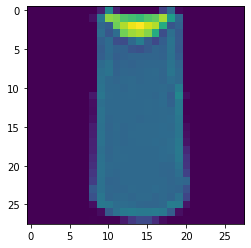

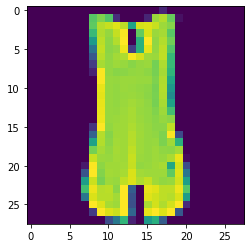

1.0


In [13]:
index = 2
show_img(train_pairs[index][0])
show_img(train_pairs[index][1])
print(train_labels[index])

#Model

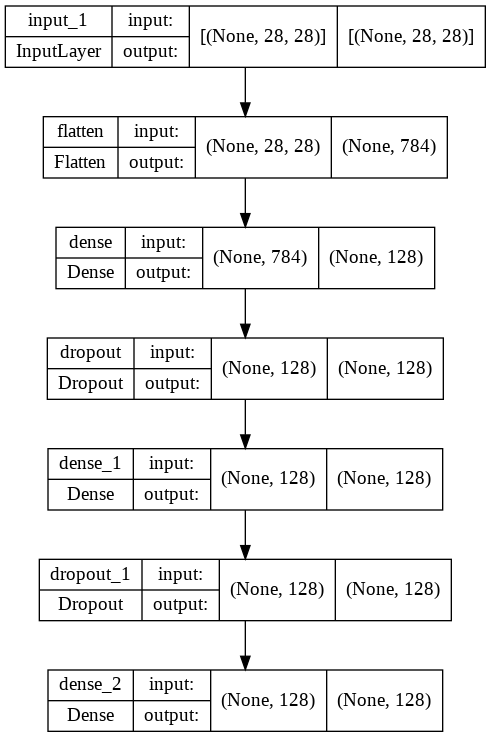

In [14]:
inputs = layers.Input(shape=(28, 28))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(128, activation='relu')(x)

base_model = tf.keras.Model(inputs, outputs)

from tensorflow.keras.utils import plot_model
plot_model(base_model, show_shapes=True)

##Check for the dims

In [15]:
x = tf.constant([[1, 1, 1], [1, 1, 1]])
tf.reduce_sum(x).numpy()

6

In [16]:
x = tf.constant([[1, 1, 1], [1, 1, 1]])
tf.reduce_sum(x, axis=1).numpy()

array([3, 3], dtype=int32)

In [17]:
x = tf.constant([[1, 1, 1], [1, 1, 1]])
tf.reduce_sum(x, axis=1, keepdims=True).numpy()

array([[3],
       [3]], dtype=int32)

In [18]:
def euclidean_distance(vect):
  x, y = vect
  sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
  return tf.sqrt(tf.maximum(sum_square,
                            tf.keras.backend.epsilon()))

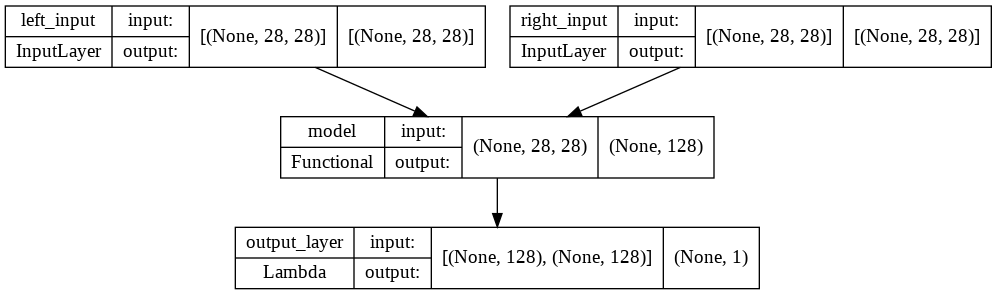

In [19]:
input_a = layers.Input(shape=(28,28,), name="left_input")
vect_output_a = base_model(input_a)

input_b = layers.Input(shape=(28,28,), name="right_input")
vect_output_b = base_model(input_b)

output = layers.Lambda(euclidean_distance, name="output_layer")([vect_output_a, vect_output_b])

model = tf.keras.Model([input_a, input_b], output)

plot_model(model, show_shapes=True)

In [20]:
def contrastive_loss(margin=1):
  def inner_contrastive_loss(y_true, y_pred):
    return y_true*(tf.square(y_pred)) + (1-y_true)*tf.square(tf.maximum(margin-y_pred, 0))
  return inner_contrastive_loss

In [21]:
train_pairs[:, 1].shape

(119980, 28, 28)

In [22]:
train_labels.dtype

dtype('float32')

In [23]:
model.compile(loss=contrastive_loss(margin=1),
              optimizer=tf.keras.optimizers.RMSprop())

history = model.fit([train_pairs[:, 0], train_pairs[:, 1]],
                    train_labels,
                    epochs=20,
                    batch_size=128,
                    validation_data=([test_pairs[:, 0], test_pairs[:, 1]],
                                     test_labels))

Epoch 1/20
938/938 [==============================] - 8s 4ms/step - loss: 0.1122 - val_loss: 0.0873
Epoch 2/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0796 - val_loss: 0.0797
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0709 - val_loss: 0.0727
Epoch 4/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0663 - val_loss: 0.0697
Epoch 5/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0630 - val_loss: 0.0712
Epoch 6/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0611 - val_loss: 0.0707
Epoch 7/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0597 - val_loss: 0.0676
Epoch 8/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0584 - val_loss: 0.0690
Epoch 9/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0573 - val_loss: 0.0669
Epoch 10/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0561 - val_loss: 0.0666